Replicate EV/REV plots for Octopamine/Rolipram sessions previously generated by Jahangir.

In [3]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform
import scipy.stats as stats

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
    sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy.core.neurons import Neurons
from neuropy.analyses.reactivation import ExplainedVariance
from neuropy.core.epoch import Epoch
from neuropy.core.session import ProcessData
from neuropy.plotting import plot_epochs
from neuropy.utils.plot_util import match_axis_lims

import ev_utils

grp_data_dir = Path("/data3/Octopamine_Rolipram/GroupData")
plot_save_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_octopamine_rollipram/Nat_plots')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up colors and rough injection times (from Jahangir plots)

In [4]:
sesh_csv = "/data3/Octopamine_Rolipram/Recording_Rats/OCT_ROL_sessions.csv"
sesh_df = pd.read_csv(sesh_csv, header=0)
sesh_df['session'] = pd.Categorical(sesh_df['session'], ['PBS', 'SAL', 'ROL', 'OCT'])
sesh_df = sesh_df.sort_values(["Animal", "session"]).reset_index().drop(columns = "index")
sesh_df

FileNotFoundError: [Errno 2] No such file or directory: '/data3/Octopamine_Rolipram/Recording_Rats/OCT_ROL_sessions.csv'

In [3]:
colors_rs = "#5599ff"
colors_nsd = "k"
colors_sd = "#eb4034"
colors_maze = "g"
colors_pre = "#424242"
colors_sd_all = [colors_pre, colors_maze, colors_sd, colors_rs]

def adjust_lightness(color, amount=0.5):
    import colorsys

    import matplotlib.colors as mc

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    c = colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    return mc.to_hex(c)

colors_all_light = [adjust_lightness(col, 1.2) for col in colors_sd_all]

## Bootstrap sessions

First calculate pairwise correlations for each session

In [235]:
# Update sesh_df to have same term for controls
sesh_df["session_type"] = sesh_df.session.apply(lambda session_id: 'PBS/SAL' if session_id in ["PBS", "SAL"] else session_id)

pcorr_df = []
sub = 0
for session_type in ["PBS/SAL", "ROL"]:
    sesh_type_df = sesh_df[sesh_df.session_type == session_type]
    for ida, animal in enumerate(sesh_type_df.Animal.unique()):
        rec_df = sesh_type_df[sesh_type_df.Animal == animal]
        if (rec_df.directory.values[0] == "None") or (rec_df.processed.values[0] == "N"):
            pass
        else:
            dir_use = Path(str(rec_df["directory"].values[0]))
            neurons_use = Neurons.load(sorted(dir_use.glob("*.neurons.npy"))[0])
            neurons_use = neurons_use.get_neuron_type(["pyr", "good", "1"])
            epochs = Epoch(epochs=None, file=sorted(dir_use.glob("*.epoch.npy"))[0])

            # Make epochs class with PRE, MAZE, 0-2.5, 2.5-5, and 5-7.5
            blk1 = [epochs["sd"].starts[0], epochs["sd"].starts[0] + 3600*2.5, "0-2.5", np.nan]
            blk2 = [epochs["sd"].starts[0] + 3600*2.5, epochs["sd"].starts[0] + 3600*5, "2.5-5", np.nan]
            blk3 = [epochs["sd"].stops[0], epochs["post"].starts[0] + 3600*2.5, "5-7.5", np.nan]
            epochs_df = deepcopy(epochs.to_dataframe())
            for blk in [blk1, blk2, blk3]:
                epochs_df.loc[-1] = blk
                epochs_df.index = epochs_df.index + 1  # shifting index
                epochs_df = epochs_df.sort_index() 
            for lcasename in ["pre", "post", "sd", "maze"]:
                epochs_df.loc[epochs_df.label == lcasename, "label"] = lcasename.upper()
            zt_epochs = Epoch(epochs_df)[["PRE", "MAZE", "0-2.5", "2.5-5", "5-7.5"]]
            
            pcorr, labels = ev_utils.get_pcorr(neurons=neurons_use, epochs=zt_epochs)
            df = pd.DataFrame(data=pcorr, columns=labels)
        
            df["session"] = sub
            sub += 1
            df["grp"] = session_type
            pcorr_df.append(df)

pcorr_df = pd.concat(pcorr_df, ignore_index=True)
np.save(grp_data_dir / "pcorrs.npy", pcorr_df, allow_pickle=True)

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid v

Now bootstrap them!

In [233]:
from stats_utils import bootstrap_resample
from ev_utils import get_ev, get_ev_mean

# Remove sessions with less than specified number of pairs!
count_df = pcorr_df.groupby("session").count().reset_index()
npairs_thresh = 2
good_sesh = count_df["session"][count_df["grp"] >= npairs_thresh]
good_sesh_bool = pcorr_df.session.apply(lambda x: x in good_sesh)

kw = dict(df=pcorr_df[good_sesh_bool], n_iter=10000, n_jobs=10)

boot_df = bootstrap_resample(level="both", apply=get_ev, **kw)
boot_save_append = f"_min{npairs_thresh}pairs"
np.save(f"/data3/Octopamine_Rolipram/GroupData/ev_in_chunks_bootstrap{boot_save_append}.npy", boot_df, allow_pickle=True)

Running bootstraps for PBS/SAL group


  0%|                                                 | 0/10000 [00:00<?, ?it/s]/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
  0%|                                       | 1/10000 [00:01<4:27:08,  

Running bootstraps for ROL group


100%|████████████████████████████████████| 10000/10000 [00:54<00:00, 182.32it/s]


/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths/plotters.py:217: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,


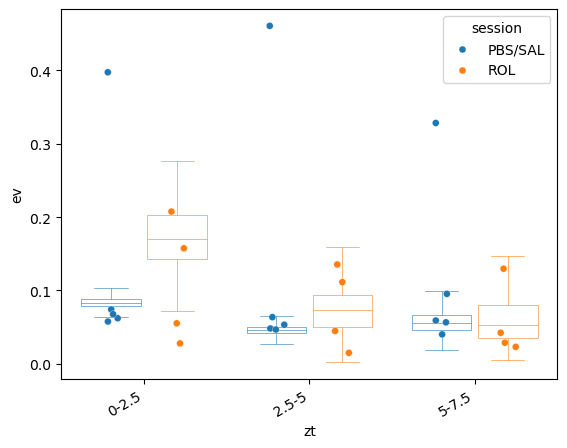

In [234]:
fig, ax = plt.subplots()
p1 = Plotter(data=boot_df, x="zt", y="ev", hue="grp", hue_order=["PBS/SAL", "ROL"], ax=ax)
p1.boxplot_sd2(legend=False)

df_use = df_comb[df_comb.session != "OCT"]
df_use = df_use[df_use.npairs > npairs_thresh]
# sns.stripplot(data=df_use, x="block", y="ev_mean", hue="session", dodge=True, 
#               edgecolor="w", linewidth=0.2, ax=ax)
# palette_light = subjects.colors_sd_light(1)
p2 = Plotter(data=ev_df, x="zt", y="ev", hue="grp", hue_order=["NSD", "SD"])
p2.striplineplot_sd()


fig.savefig(plot_save_dir / f"ROL_v_SAL_ev_in_blocks{boot_save_append}.pdf")

## Calculate EV in chunks and plot with bootstrapped values


In [4]:
ev_dict_all3 = np.load("/data3/Octopamine_Rolipram/GroupData/ev_comb_pyr_only_wave_exclude.npy", allow_pickle=True).item()

In [237]:
# session_id = "A11_ROL"
# ev_use = ev_dict_all3[session_id]
df_comb = []
n = 0
for session_id, ev_use in ev_dict_all3.items():
    type = 'PBS/SAL' if session_id.split("_")[1] in ["PBS", "SAL"] else session_id.split("_")[1]
    animal = session_id.split("_")[0]
    t_bins_hrs = (ev_use.matching_time - ev_use.matching_time[0])/3600
    tlims = [[0, 2.5], [2.5, 5.0], [5.0, 7.5]]
    

    for tlim, tlabel in zip(tlims, ["0-2.5", "2.5-5", "5-7.5"]):
        tbool = (t_bins_hrs >= tlim[0]) & (t_bins_hrs < tlim[1])
        ev_mean = np.mean(ev_use.ev[tbool])
        df_comb.append(pd.DataFrame({"block": tlabel, "ev_mean": ev_mean, "animal": animal, "session": type,
                                     "npairs": ev_use.n_pairs}, index=[n]))
        n += 1
df_comb = pd.concat(df_comb, axis=0)
np.save(grp_data_dir / "ev_in_chunks.npy", df_comb, allow_pickle=True)

df_comb.head(6)

,block,ev_mean,animal,session,npairs
0,0-2.5,0.397364,A11,PBS/SAL,21
1,2.5-5,0.460640,A11,PBS/SAL,21
2,5-7.5,0.328227,A11,PBS/SAL,21
3,0-2.5,NaN,A11,ROL,1
4,2.5-5,NaN,A11,ROL,1
5,5-7.5,NaN,A11,ROL,1


In [248]:
pd.DataFrame(np.load(grp_data_dir / f"ev_in_chunks_bootstrap{boot_save_append}.npy", allow_pickle=True), 
             columns = ["zt", "ev", "grp"])

,zt,ev,grp
0,0-2.5,0.080166,PBS/SAL
1,2.5-5,0.043118,PBS/SAL
2,5-7.5,0.053959,PBS/SAL
3,0-2.5,0.082456,PBS/SAL
4,2.5-5,0.045834,PBS/SAL
...,...,...,...
59995,2.5-5,0.068746,ROL
59996,5-7.5,0.049134,ROL
59997,0-2.5,0.243665,ROL
59998,2.5-5,0.099839,ROL


In [244]:
np.load(grp_data_dir / "ev_in_chunks.npy", allow_pickle=True)

array([['0-2.5', 0.39736360219613703, 'A11', 'PBS/SAL', 21],
       ['2.5-5', 0.4606398755132772, 'A11', 'PBS/SAL', 21],
       ['5-7.5', 0.3282267771385527, 'A11', 'PBS/SAL', 21],
       ['0-2.5', nan, 'A11', 'ROL', 1],
       ['2.5-5', nan, 'A11', 'ROL', 1],
       ['5-7.5', nan, 'A11', 'ROL', 1],
       ['0-2.5', 0.19303882852695015, 'A11', 'OCT', 42],
       ['2.5-5', 0.1710139281483441, 'A11', 'OCT', 42],
       ['5-7.5', 0.09935186498878551, 'A11', 'OCT', 42],
       ['0-2.5', 0.062138326707688, 'A14', 'PBS/SAL', 4473],
       ['2.5-5', 0.04814129585390106, 'A14', 'PBS/SAL', 4473],
       ['5-7.5', 0.05901264338228349, 'A14', 'PBS/SAL', 4473],
       ['0-2.5', 0.05518326163392663, 'A14', 'ROL', 18765],
       ['2.5-5', 0.0447566736423242, 'A14', 'ROL', 18765],
       ['5-7.5', 0.02310489494906603, 'A14', 'ROL', 18765],
       ['0-2.5', nan, 'A14', 'OCT', 9],
       ['2.5-5', nan, 'A14', 'OCT', 9],
       ['5-7.5', nan, 'A14', 'OCT', 9],
       ['0-2.5', 0.057623067027054685, 'BG'

/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths/plotters.py:217: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,


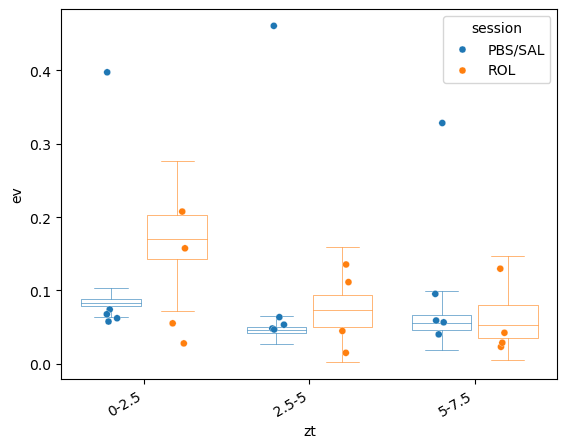

In [254]:
boot_save_append = f"_min{npairs_thresh}pairs"
# df_comb = np.load(grp_data_dir / "ev_in_chunks.npy", allow_pickle=True).item()[0]
df_comb = pd.DataFrame(np.load(grp_data_dir / "ev_in_chunks.npy", allow_pickle=True),
                       columns=["block", "ev_mean", "Animal", "session", "npairs"])
boot_df = pd.DataFrame(np.load(grp_data_dir / f"ev_in_chunks_bootstrap{boot_save_append}.npy", allow_pickle=True), 
                       columns=["zt", "ev", "grp"])

fig, ax = plt.subplots()
p1 = Plotter(data=boot_df, x="zt", y="ev", hue="grp", hue_order=["PBS/SAL", "ROL"], ax=ax)
p1.boxplot_sd2(legend=False)

df_use = df_comb[df_comb.session != "OCT"]
df_use = df_use[df_use.npairs > npairs_thresh]
sns.stripplot(data=df_use, x="block", y="ev_mean", hue="session", dodge=True, 
              edgecolor="w", linewidth=0.2, ax=ax)

fig.savefig(plot_save_dir / f"ROL_v_SAL_ev_in_blocks{boot_save_append}.pdf")

## Power Analysis
1) Calculate weighted mean and std due to vast differences in # of neuron-pairs.
2) Do brute force power analysis by adding in an additional animal to each group until you get p < 0.05 for first block and then for second block

In [239]:
# Define lambda functions to get weighted mean and standard deviation
from statsmodels.stats.weightstats import DescrStatsW
weighted_mean = lambda df: DescrStatsW(df.ev_mean, weights=df.npairs, ddof=0).mean
weighted_std = lambda df: DescrStatsW(df.ev_mean, weights=df.npairs, ddof=0).std

In [238]:
ev_sd = np.load("/data3/Octopamine_Rolipram/GroupData/ev_in_chunks_sd.npy", allow_pickle=True).item()
ev_sd = pd.DataFrame(ev_sd["data"])
ev_sd.sample(6)

,ev,rev,ev_diff,ev_perc,zt,session,name,sex,grp
32,0.031575,0.002123,0.029451,1386.992449,5-7.5,10,RatUDay4,male,SD
6,0.231814,0.003546,0.228267,6436.692971,0-2.5,2,RatSDay2,female,NSD
29,0.038607,0.000471,0.038136,8093.391877,5-7.5,9,RatUDay1,male,SD
11,0.029423,0.017153,0.012270,71.535491,5-7.5,3,RatUDay2,male,NSD
25,0.026449,0.008215,0.018234,221.961761,2.5-5,8,RatSDay3,female,SD
14,0.042271,0.127763,-0.085492,-66.914541,5-7.5,4,RatVDay1,male,NSD


In [12]:
ev_sd_stats = ev_sd.drop(columns=["rev", "ev_diff", "ev_perc", "session", "name", "sex"]).groupby(["grp", "zt"]).count().rename(columns={"ev": "n"}).reset_index()
ev_sd_stats["ev_mean"] = ev_sd.groupby(["grp", "zt"]).mean(numeric_only=True).reset_index()["ev"]
ev_sd_stats["ev_std"] = ev_sd.groupby(["grp", "zt"]).std(numeric_only=True).reset_index()["ev"]
ev_sd_stats

,grp,zt,n,ev_mean,ev_std
0,NSD,0-2.5,6,0.155618,0.084213
1,NSD,2.5-5,6,0.067306,0.035342
2,NSD,5-7.5,6,0.073258,0.085710
3,SD,0-2.5,7,0.074081,0.081213
4,SD,2.5-5,7,0.016285,0.016965
5,SD,5-7.5,7,0.037279,0.004609


In [279]:
def get_tstats(df_in, grps = ["NSD", "SD"], zt_list = ["0-2.5", "2.5-5", "5-7.5"]):
    """Handwritten function to get t-stats, checks out with scipy.stats"""
    tstat = []
    dof = []
    pval = []
    grp0_mean, grp1_mean = [], []
    for zt in zt_list:
        df_use = df_in[df_in.zt == zt]
        df_grp0 = df_use[df_use.grp == grps[0]].reset_index()
        df_grp1 = df_use[df_use.grp == grps[1]].reset_index()
        tstat.append(((df_grp0.ev_mean - df_grp1.ev_mean) / np.sqrt(df_grp0.ev_std ** 2 / df_grp0.n + df_grp1.ev_std ** 2 / df_grp1.n)).values[0])
        dof.append(((df_grp0.ev_std ** 2 / df_grp0.n + df_grp1.ev_std ** 2 / df_grp1.n) ** 2 / 
                   (df_grp0.ev_std ** 4 / (df_grp0.n ** 2) / (df_grp0.n - 1) + df_grp1.ev_std ** 4 / (df_grp1.n ** 2) / (df_grp1.n - 1))).values[0])
        pval.append(2 * (1 - stats.t.cdf(np.abs(tstat[-1]), dof[-1])))
        grp0_mean.append(df_grp0.ev_mean.values[0])
        grp1_mean.append(df_grp1.ev_mean.values[0])
        
    return pd.DataFrame({"zt": zt_list, f"{grps[0]}mean": grp0_mean, f"{grps[1]}mean": grp1_mean,
                         "tstat": tstat, "dof": dof, "pval": pval})

get_tstats(ev_sd_stats)

,zt,NSDmean,SDmean,tstat,dof,pval
0,0-2.5,0.155618,0.074081,1.769123,10.557909,0.105707
1,2.5-5,0.067306,0.016285,3.231385,6.944417,0.014583
2,5-7.5,0.073258,0.037279,1.026975,5.024794,0.351305


In [280]:
# Get t-stats for Rolipram
df_comb["ev_mean"] = df_comb["ev_mean"].astype("float")
df_rol_stats = df_comb[~np.isnan(df_comb.ev_mean)].groupby(["session", "block"]).apply(weighted_mean).reset_index().rename(columns={"session": "grp", "block": "zt", 0: "ev_mean"})
df_rol_stats["ev_std"] = df_comb[~np.isnan(df_comb.ev_mean)].groupby(["session", "block"]).apply(weighted_std).reset_index()[0]
df_rol_stats["n"] = df_comb[~np.isnan(df_comb.ev_mean)].groupby(["session", "block"]).count().reset_index()["ev_mean"]
df_rol_stats

,grp,zt,ev_mean,ev_std,n
0,OCT,0-2.5,0.193039,0.000000e+00,1
1,OCT,2.5-5,0.171014,0.000000e+00,1
2,OCT,5-7.5,0.099352,1.387779e-17,1
3,PBS/SAL,0-2.5,0.069019,1.183604e-02,5
4,PBS/SAL,2.5-5,0.050375,1.377681e-02,5
5,PBS/SAL,5-7.5,0.057756,1.645571e-02,5
6,ROL,0-2.5,0.131026,7.534573e-02,4
7,ROL,2.5-5,0.089563,4.614773e-02,4
8,ROL,5-7.5,0.073428,5.162161e-02,4


In [282]:
# Iterate through, adding an additional animal to each group and calculate tstat and pvalue assuming the same mean and variance
from copy import deepcopy
df_iter = []
for n in np.arange(0, 5, 1):
    df_use = deepcopy(df_rol_stats)
    df_use["n"] = df_use["n"] + n
    nsal = df_use[df_use.grp == "PBS/SAL"]["n"].values[0]
    nrol = df_use[df_use.grp == "ROL"]["n"].values[0]
    tstats_df = get_tstats(df_use, grps=["PBS/SAL", "ROL"], zt_list=["0-2.5", "2.5-5", "5-7.5"])
    tstats_df["nPBS/SAL"] = nsal
    tstats_df["nROL"] = nrol
    df_iter.append(tstats_df)
power_df = pd.concat(df_iter, axis=0, ignore_index=True)
power_df = power_df.rename(columns={"pval": "pval (2-sided)"})
power_df.to_csv(grp_data_dir / "power_analysis.csv")
power_df

,zt,PBS/SALmean,ROLmean,tstat,dof,pval (2-sided),nPBS/SAL,nROL
0,0-2.5,0.069019,0.131026,-1.629919,3.118708,0.198155,5,4
1,2.5-5,0.050375,0.089563,-1.640883,3.429971,0.187862,5,4
2,5-7.5,0.057756,0.073428,-0.583915,3.490292,0.594904,5,4
3,0-2.5,0.069019,0.131026,-1.821570,4.164797,0.139777,6,5
4,2.5-5,0.050375,0.089563,-1.832025,4.595946,0.131553,6,5
5,5-7.5,0.057756,0.073428,-0.651817,4.679292,0.545166,6,5
6,0-2.5,0.069019,0.131026,-1.994856,5.211813,0.100292,7,6
7,2.5-5,0.050375,0.089563,-2.004904,5.765066,0.093739,7,6
8,5-7.5,0.057756,0.073428,-0.713235,5.871821,0.503047,7,6
9,0-2.5,0.069019,0.131026,-2.154226,6.259407,0.072785,8,7
